# Airborne MT forward modelling and inversion notebook V0.3

Note: this notebook can be modified to do qamt or controlled source. TODO

In [3]:
# import SimPEG.dask as simpeg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from SimPEG.electromagnetics import natural_source as ns
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver


## Loading the simulation

Load the *.msh file and *.mod file which are UBC formatted. We can extract the active cells by searching for the value used to indicate air cells on line 10 of the following cell

A histogram of the model is generated to get an idea of how many units are present

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\mixins\mesh_io.py:594: FutureWarning: TensorMesh.readUBC has been deprecated and will be removed indiscretize 1.0.0. please use TensorMesh.read_UBC
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.readModelUBC has been deprecated, please use TreeMesh.read_model_UBC. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


(54504,) 54504 34840


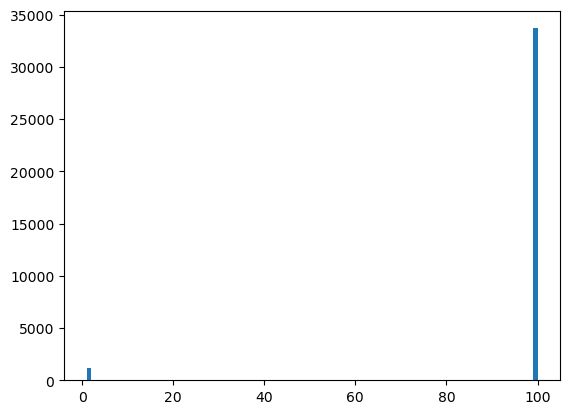

0.01 1.0


In [4]:
# let import the mesh in UBC format
mesh_file = r".\octree_mesh\octree_mesh.txt"
mesh = discretize.TreeMesh.readUBC(mesh_file)

# load the conductivity model
conductivity_file = r".\octree_model\octree_model.con"
model = discretize.TreeMesh.readModelUBC(mesh, conductivity_file)

# extract the acive files
active = model > 1e-8

# model[model == -1] = 50

print(model.shape, mesh.nC, active.sum())

plt.hist(1 / model[active], 100)
plt.show()

print(model[active].min(), model[active].max())


## Load the receiver stations array

Simply load in a CSV file with utm easting, northing and elevation.

receiver numbers: (169, 3)


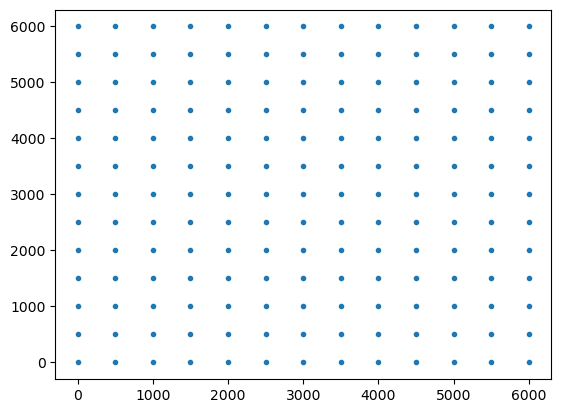

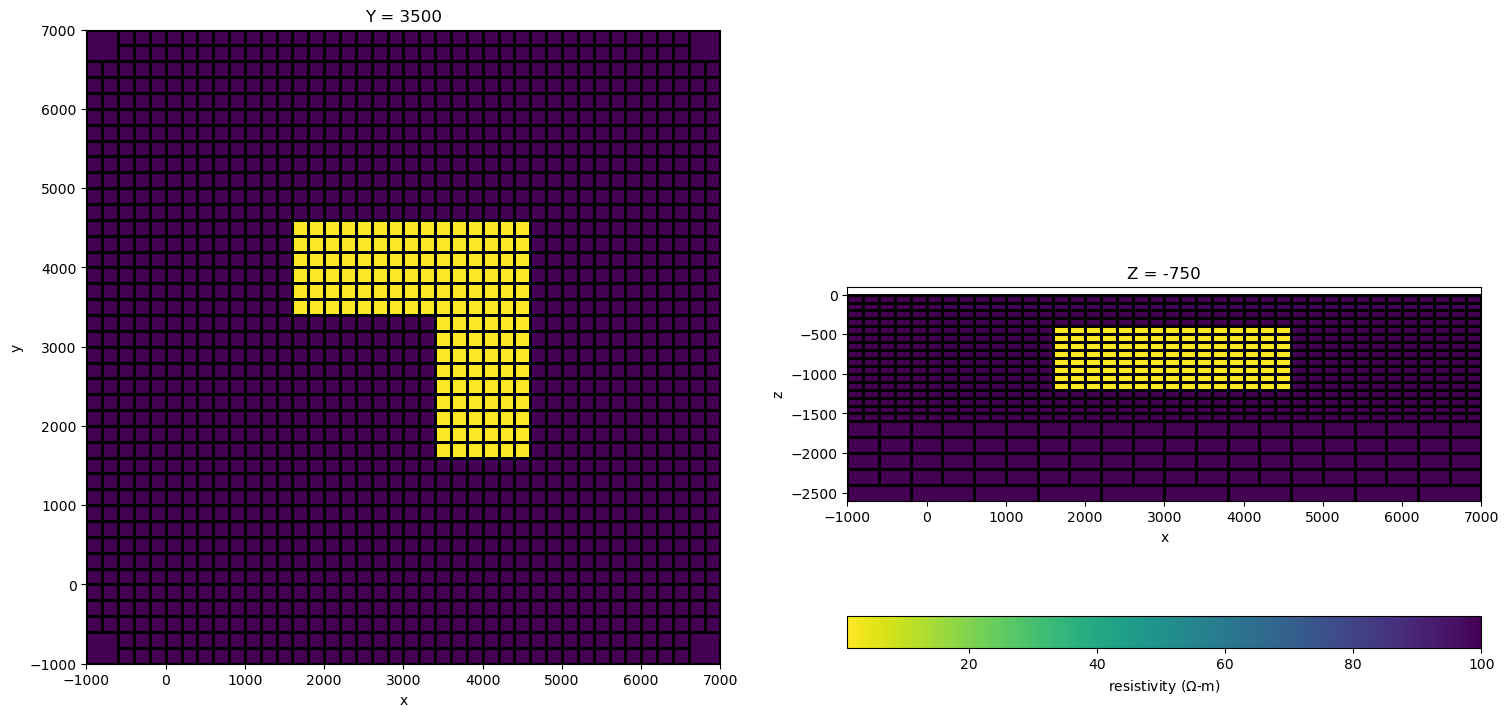

In [18]:
# create receivers
rx_x, rx_y = np.meshgrid(np.arange(0, 6500, 500), np.arange(0, 6500, 500))
receivers = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.ones((np.prod(rx_x.shape), 1))*50.0))
print(f"receiver numbers: {receivers.shape}")

plt.plot(receivers[:, 0], receivers[:, 1], '.')
plt.show()


# ---------------------------------------------------------------------------------------------------------------------------------------

# Plot input model

#

plt_model = 1 / model
plt_model[~active] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(18, 10))

collect_obj = mesh.plot_slice(plt_model, ax=ax[0], ind=int(120), grid=True, normal='Z', clim=[1, 100], pcolor_opts={"cmap": 'viridis_r'})
# color_bar = plt.colorbar(collect_obj[0])
# ax[0].plot(source_locations[:, 0], source_locations[:, 1], '-g', linewidth=6)
# ax[0].text(300, -250, 'Transmiter', fontsize=20, color='white', fontweight='bold')

ax[0].set_xlim([-1000, 7000])
ax[0].set_ylim([-1000, 7000])
ax[0].set_aspect('equal')
ax[0].set_title('Y = 3500')
# ax[0].axis('equal')
collect_obj = mesh.plot_slice(plt_model, ax=ax[1], ind=int(66), grid=True, normal='Y', clim=[1, 100], pcolor_opts={"cmap": 'viridis_r'})
# color_bar = plt.colorbar(collect_obj[0])
ax[1].set_xlim([-1000, 7000])
ax[1].set_ylim([-2600, 100])
ax[1].set_aspect('equal')
ax[1].set_title('Z = -750')
fig.colorbar(collect_obj[0], label=r'resistivity ($\Omega$-m)', orientation='horizontal')
plt.show()



## Load up UBC data

In [4]:
ubc_read = np.genfromtxt(r".\data_input\FWDdata.txt")

frequencies = [10, 50, 200]
# organise data by frequency index
ubc_dat = {}

for ii in range(len(frequencies)):

    ubc_dat[ii] = {

        'tzxr': [],
        'tzxi': [],
        'tzyr': [],
        'tzyi': [],
    }

fcnt = 0
findx = 0

for ii in range(ubc_read.shape[0]):

    if len(ubc_read[ii, :]) > 1:

        if fcnt == 169:

            fcnt = 0
            findx += 1

            ubc_dat[findx]['tzxr'] += [ubc_read[ii, 5]]
            ubc_dat[findx]["tzxi"] += [-ubc_read[ii, 6]]
            ubc_dat[findx]['tzyr'] += [ubc_read[ii, 3]]
            ubc_dat[findx]["tzyi"] += [-ubc_read[ii, 4]]

        else:

            ubc_dat[findx]['tzxr'] += [ubc_read[ii, 5]]
            ubc_dat[findx]["tzxi"] += [-ubc_read[ii, 6]]
            ubc_dat[findx]['tzyr'] += [ubc_read[ii, 3]]
            ubc_dat[findx]["tzyi"] += [-ubc_read[ii, 4]]

        fcnt += 1

# print(len(ubc_dat[findx - 1]['tzxr']))

# now create a vectore similar to dobs in simpeg
ubc_obs = []

for ii in range(3):

    ubc_obs += ubc_dat[ii]['tzxr']
    ubc_obs += ubc_dat[ii]['tzxi']
    ubc_obs += ubc_dat[ii]['tzyr']
    ubc_obs += ubc_dat[ii]['tzyi']

print(np.array(ubc_obs).shape)
ubc_obs = np.array(ubc_obs)

(2028,)


## Setting up the simulation

Here the background is set to the median of the model provided. This may or may not need to be adjusted depedning on the experiment.

The simpeg framework is now incorporated by defining the receiver type and components. This can be modified for impedance data or tipper. For tipper data replace the receiver simpeg object type with: `Point3DTipper(receivers, orientation=rx_orientation, component='real')` and `Point3DTipper(receivers, orientation=rx_orientation, component='imag')` on starting on line 12 and 17.

The model slice is also generated to confirm simulated targets.

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.plotSlice has been deprecated, please use TreeMesh.plot_slice. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


(-9800.0, 15800.0, -12800.0, 12800.0)

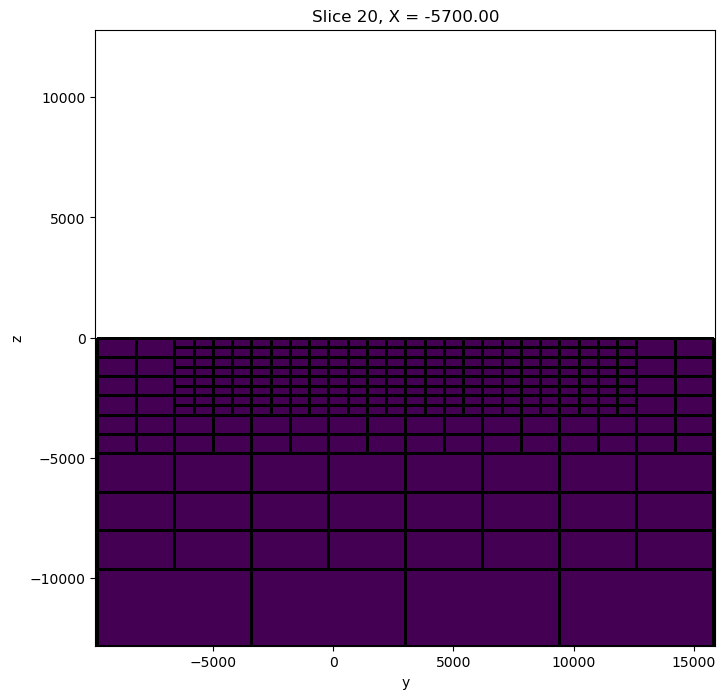

In [5]:
# set frequencies
freqs = ['10', '50', '200']

background = 100 # np.median(model[active])
# create background conductivity model
sigBG = np.zeros(mesh.nC) + 1 / background
sigBG[~active] = 1e-8

# Make a receiver list
rx_list = []
for rx_orientation in ['zx', 'zy']:
    
    rx_list.append(
        
        ns.receivers.Point3DTipper(receivers,
                                   orientation=rx_orientation,
                                   component='real'
        )
    )
    rx_list.append(

        ns.receivers.Point3DTipper(receivers,
                                   orientation=rx_orientation,
                                   component='imag'
        )
    )

# Source list
src_list = [ns.sources.Planewave_xy_1Dprimary(rx_list, frequency=float(f)) for f in freqs]

# Survey MT
survey = ns.Survey(src_list)
# survey.drape_topography(mesh, active, option='top')                       # drape topo

# plot the mesh
model_plot = model.copy()
model_plot[~active] = np.nan
ind_slice = int(20)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
mesh.plotSlice(model_plot, normal="X", ax=ax, ind=ind_slice, grid=True)
ax.axis("equal")


## Running the forward simulation

Here simpeg map and simulation objects are created which are then used to calculate the forward data using the geological model imported in UBC format.

In [1]:

# Set the mapping
actMap = maps.InjectActiveCells(
    mesh=mesh, indActive=active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * actMap

# Setup the problem object
sim = ns.simulation.Simulation3DPrimarySecondary(
    
    mesh,
    survey=survey,
    sigmaMap=mapping,
    sigmaPrimary=sigBG,
    solver=Solver

)

sim.model = sigBG[active]

# -------------------------------------------------------------

# calculate the fields

#

import time
source_list = src_list
models = {

    "L_block": np.log(model[active]),
    "half_space": np.log(sigBG[active])
}

fields = {}

for key, sig in models.items():
    if key not in fields.keys(): 
        print(f"starting {key}")
        t = time.time()
        fields[key] = sim.fields(sig)
        print(f"done {key}... elapsed time: {time.time()-t:1.1e}s \n")

sim.survey.dtrue = sim.dpred(np.log(model[active]), f=fields["L_block"])
# create observations
sim.survey.dobs = sim.survey.dtrue


NameError: name 'maps' is not defined

## Plotting the simulation data

Line 11 and 20 will need to be adjusted accoringly depending on the data being observed.

[-0.00064783  0.00027391  0.00191354 ... -0.0002825  -0.00022549
 -0.00013932]
169


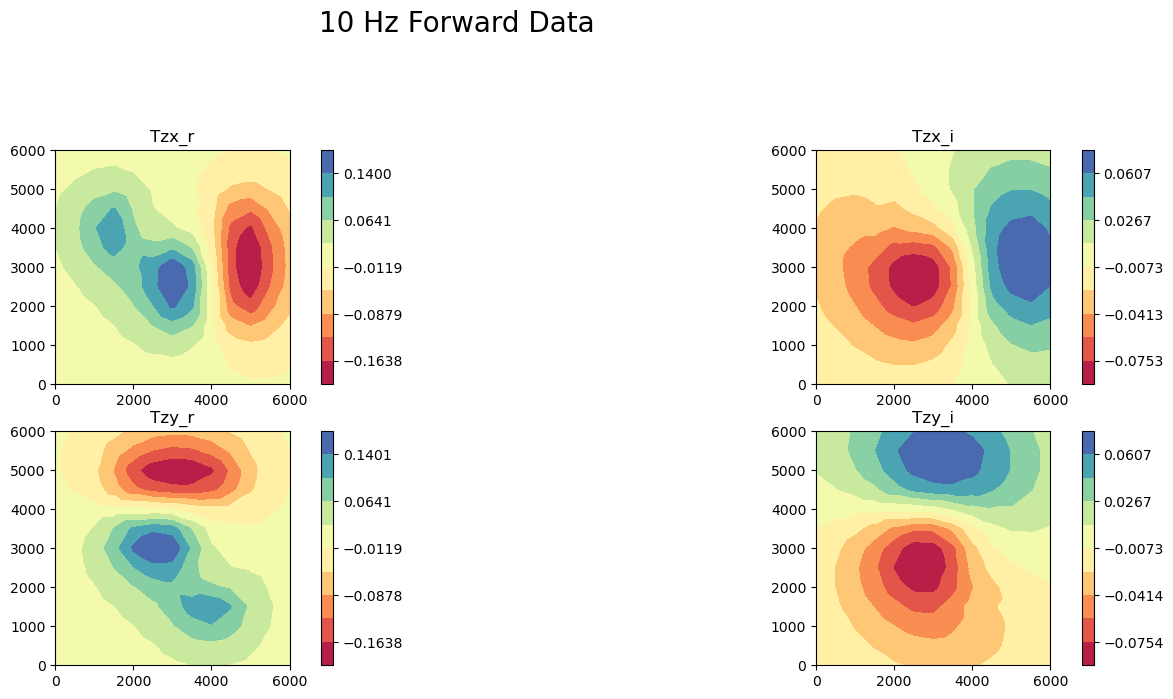

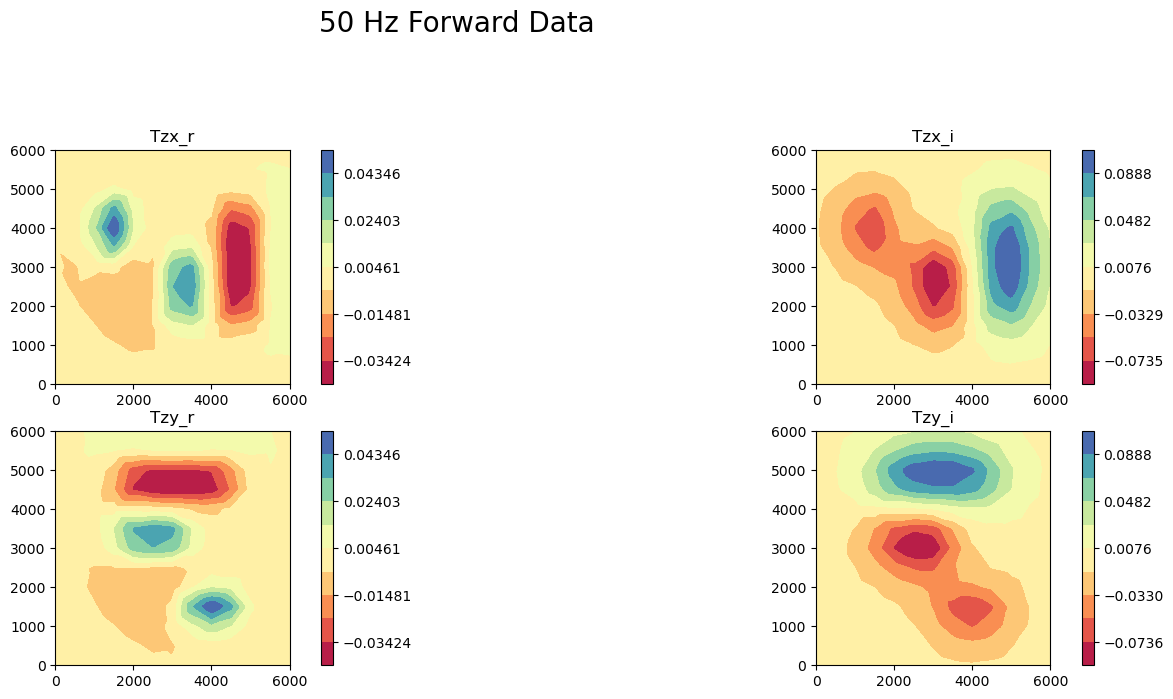

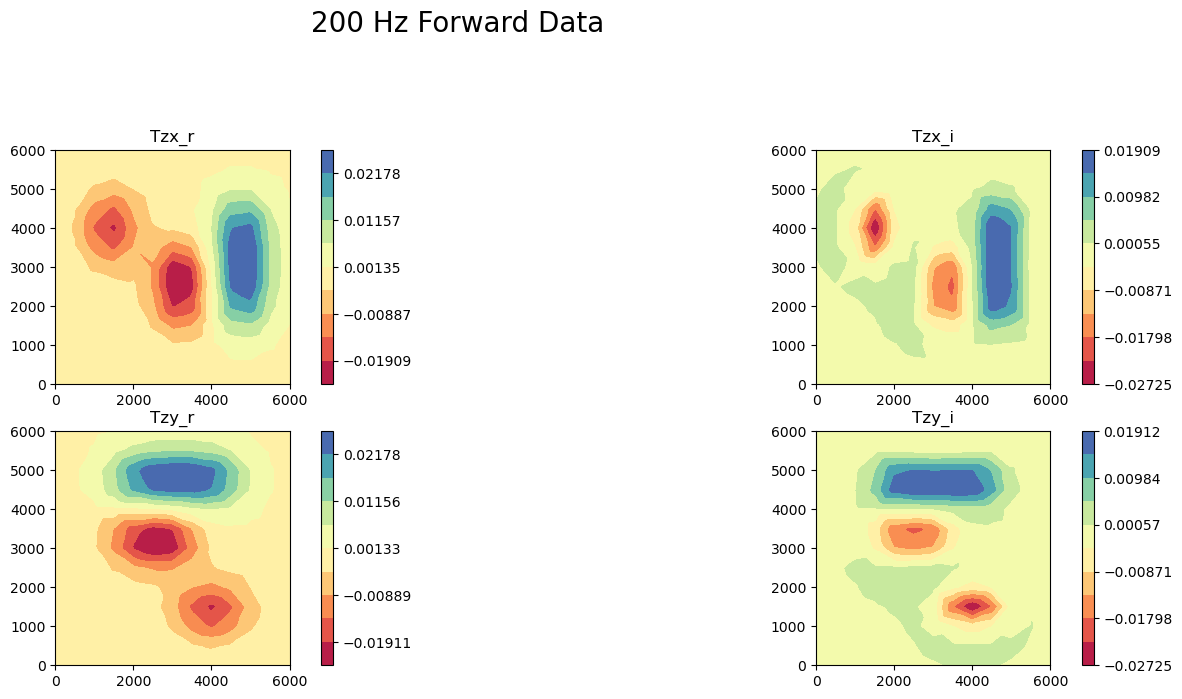

[0.00103239 0.00102858 0.00500256] (2028,)


In [7]:
print(survey.dobs)
# Assign uncertainties
std = 0.05  # 5% std
sim.survey.std = np.abs(survey.dobs) * std
# make data object
fwd_data = data.Data(sim.survey)

# reshape data for plotting
print(receivers.shape[0])
num_station = receivers.shape[0]

num_frequencies = len(freqs)

num_sets = int(survey.dobs.shape[0] / len(freqs))
dnew = np.reshape(survey.dobs, (num_frequencies, num_sets))
stdnew = np.reshape(survey.std, (num_frequencies, num_sets))

# do the ubc data
ubc_dnew = np.reshape(ubc_obs, (num_frequencies, num_sets))

cnt = 0

profile_data = {

    '10':{

    'real': [],
    'imag': []

    },

    '50':{

    'real': [],
    'imag': []

    },

    '200':{

    'real': [],
    'imag': []

    }
}

ubc_profile_data = {

    '10':{

    'real': [],
    'imag': []

    },

    '50':{

    'real': [],
    'imag': []

    },

    '200':{

    'real': [],
    'imag': []

    }
}


for freq in freqs:
    cnt_comp = 0
    # comps_ = ['rho_xy', 'phi_xy', 'rho_yx', 'phi_yx']
    comps_ = ['Tzx_r', 'Tzx_i', 'Tzy_r', 'Tzy_i']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        pert = 1e-2
        pert_diag = 1e-3  #np.percentile(np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]), 10)
        
        if comps_[rx_orientation][-2:] == 'xx':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.1) + pert
        
        elif comps_[rx_orientation][-2:] == 'yy':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.1) + pert
        
        elif freq == '200':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.05) + 0.005
        
        else:
#             print(pert_diag)
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.05) + pert_diag

        if comps_[rx_orientation] == 'Tzx_r':
            # print(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)].shape)
            profile_data[freq]['real'].append(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            ubc_profile_data[freq]['real'].append(ubc_dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
        
        elif comps_[rx_orientation] == 'Tzx_i':
            profile_data[freq]['imag'].append(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            ubc_profile_data[freq]['imag'].append(ubc_dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = utils.plot_utils.plot2Ddata(receivers, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax, contourOpts={'cmap':'Spectral'})
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(freq + ' Hz Forward Data', fontsize='20')
plt.show()
print(mkvc(stdnew)[:3], stdnew.flatten('F').shape)

## Plotting figures

(13,) 10 117
(13,) 50 117
(13,) 200 117


c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh.edgeCurl has been deprecated, please use TreeMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


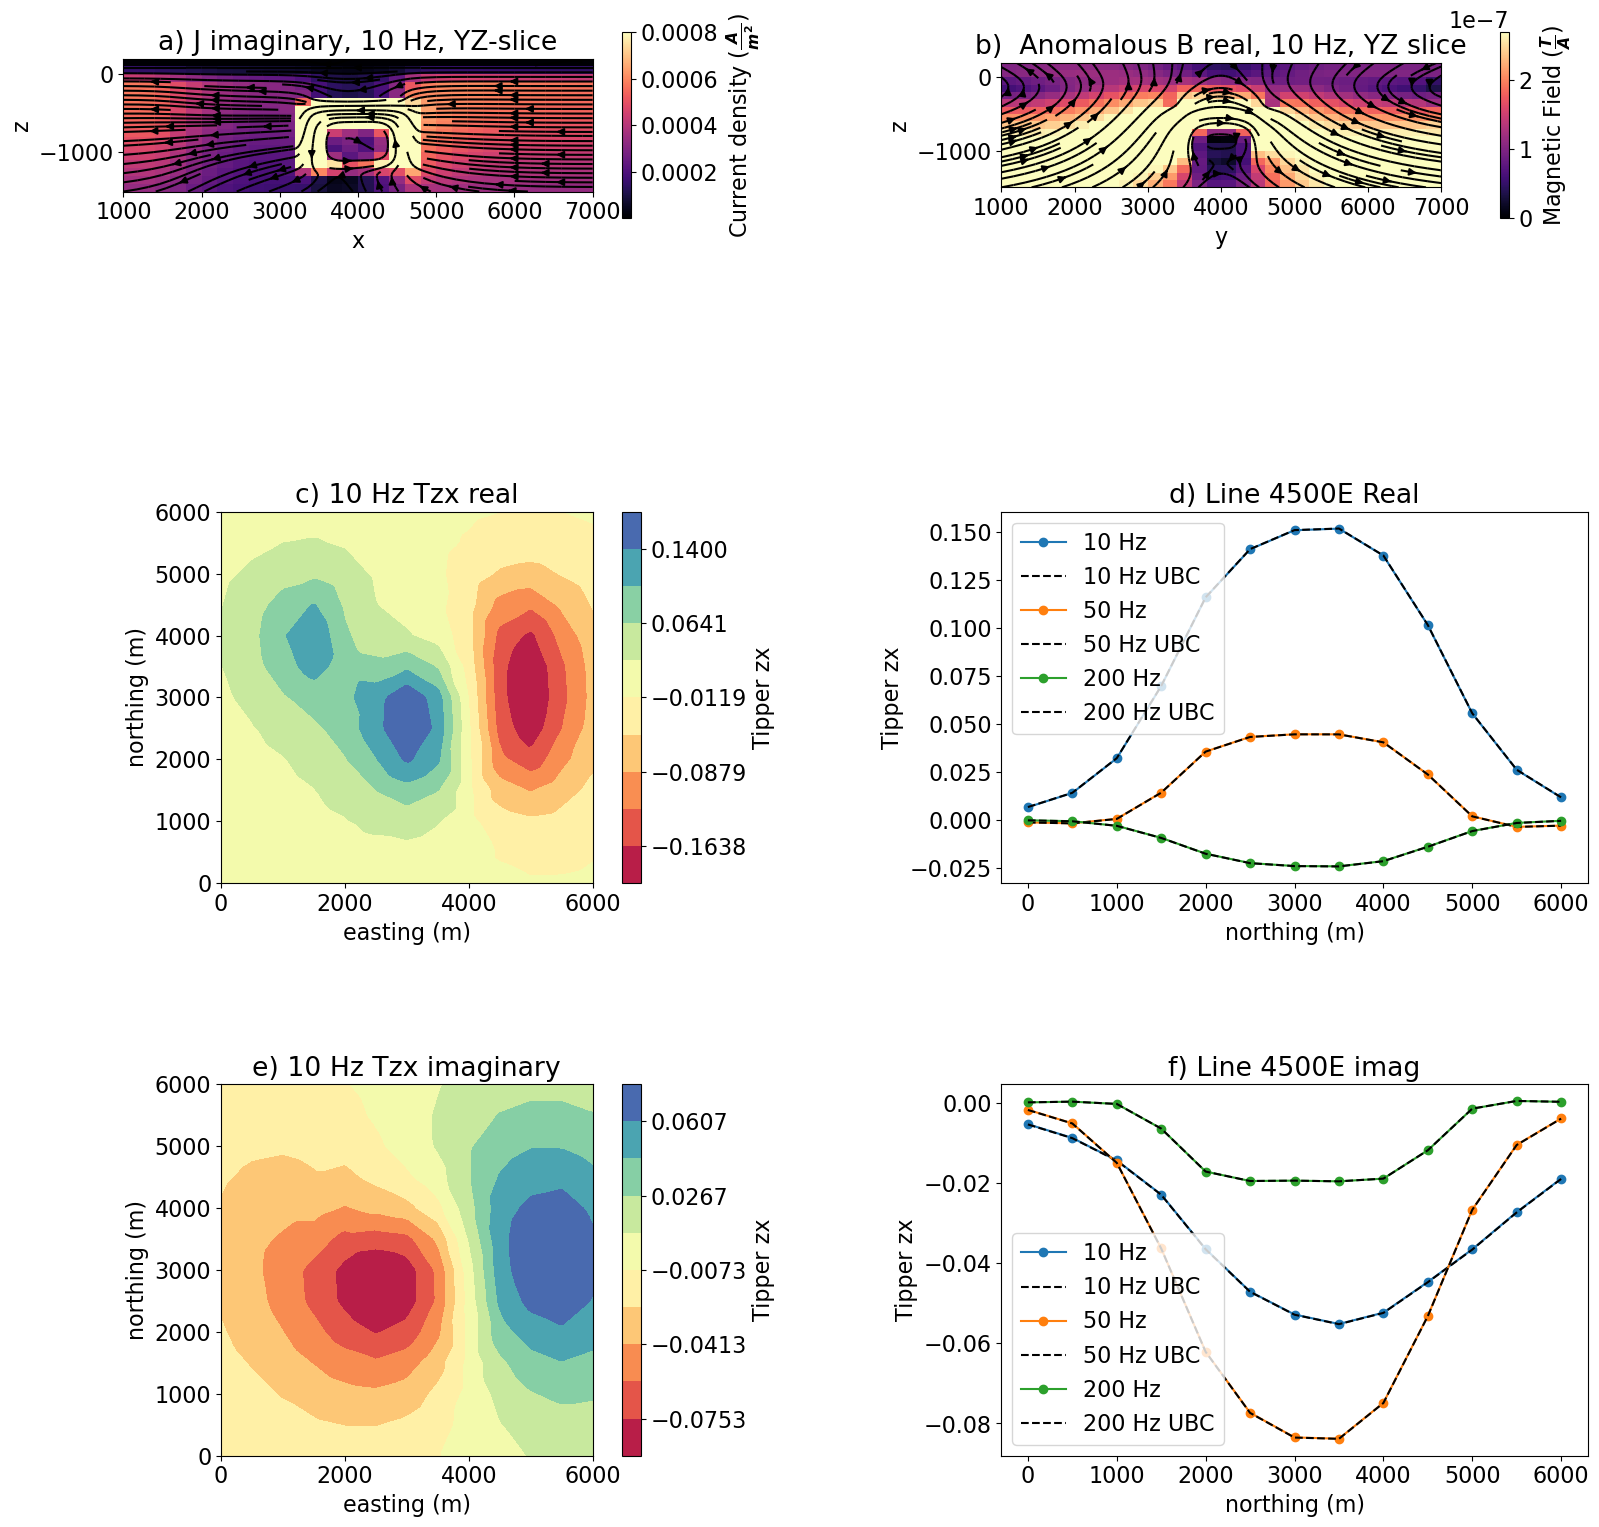

[4500.    0.   50.]


In [17]:
from tree_plot import streamplot_tree
from matplotlib.colors import LogNorm, Normalize
import matplotlib
font = {
        'size'   : 16}
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('font', **font)

# ---------------------------------------------------------------------------------------------------------------------------

# plot the profile subplots

#

data_dict = fwd_data

# print(fields, rx_list[:2])

# lets plot some plots
fig, ax = plt.subplots(3, 2, figsize=(18, 18))
idx = 9

for key in profile_data.keys():
    print(profile_data[key]['real'][0][(13*8):(13*8 + 13)].shape, key, 13*idx)
    ax[1, 1].plot(np.arange(0, 6500, 500), -profile_data[key]['real'][0][(13*idx):(13*idx + 13)], 'o-', label=f"{key} Hz")
    ax[1, 1].plot(np.arange(0, 6500, 500), ubc_profile_data[key]['real'][0][(13*idx):(13*idx + 13)], '--k', label=f"{key} Hz UBC")
    ax[2, 1].plot(np.arange(0, 6500, 500), -profile_data[key]['imag'][0][(13*idx):(13*idx + 13)], 'o-', label=f"{key} Hz")
    ax[2, 1].plot(np.arange(0, 6500, 500), ubc_profile_data[key]['imag'][0][(13*idx):(13*idx + 13)], '--k', label=f"{key} Hz UBC")

ax[1, 1].legend()
ax[1, 1].set_title('d) Line 4500E Real')
ax[1, 1].set_xlabel('northing (m)')
ax[1, 1].set_ylabel('Tipper zx')
ax[2, 1].set_title('f) Line 4500E imag')
ax[2, 1].set_xlabel('northing (m)')
ax[2, 1].set_ylabel('Tipper zx')
ax[2, 1].legend()


# ---------------------------------------------------------------------------------------------------------------------------

# plot the plan-map subplots

#

key = "10"
im = utils.plot_utils.plot2Ddata(receivers, profile_data[key]['real'][0], ax=ax[1, 0], contourOpts={'cmap':'Spectral'})
ax[1, 0].set_title(f"c) {key} Hz Tzx real")
ax[1, 0].set_xlabel('easting (m)')
ax[1, 0].set_ylabel('northing (m)')
plt.colorbar(im[0], label=r'Tipper zx')

# ax[1, 0].text(-0.1, 1.15, 'c)', transform=ax[1, 0].transAxes,
#       fontsize=16, fontweight='bold', va='top', ha='right')

im = utils.plot_utils.plot2Ddata(receivers, profile_data[key]['imag'][0], ax=ax[2, 0], contourOpts={'cmap':'Spectral'})
ax[2, 0].set_title(f"e) {key} Hz Tzx imaginary")
ax[2, 0].set_xlabel('easting (m)')
ax[2, 0].set_ylabel('northing (m)')
plt.colorbar(im[0], label=r'Tipper zx')

# ---------------------------------------------------------------------------------------------------------------------------

# plot the slice of currents and B-field subplots

#

frequencies = [10, 50, 200]

xlim = np.r_[1000, 7000]
ylim = np.r_[-1500, 200]

key = "L_block"
src_ind = 0

out = streamplot_tree(
    mesh,
    fields[key][source_list[src_ind], "j"][:, 0].imag, normal="Y", ax=ax[0, 0],
    pcolor_opts={"norm": Normalize(vmax=8e-4), "cmap": 'magma'},
    streamplot_opts={'color': 'black'},range_x1=xlim, range_x2=ylim,
)
plt.colorbar(out[0], ax=ax[0, 0], shrink=0.5, label=r'Current density ($\frac{A}{m^2}$)')
# ax[0, 0].set_xlim(xlim)
# ax[0, 0].set_ylim(ylim)
ax[0, 0].set_title(f"a) J imaginary, {frequencies[src_ind]} Hz, YZ-slice")
ax[0, 0].set_aspect(1)


key = "L_block"
src_ind = 0
subtract = "halfspace" 

plotme = fields[key][source_list[src_ind], "b"][:, 0].real
# if subtract is not None:
#     plotme = plotme - fields[subtract][source_list[src_ind], "b"][:, 0].real

out = streamplot_tree(
    mesh,
    plotme, normal="X", ax=ax[0, 1],
    pcolor_opts={"norm": Normalize(vmin=0, vmax=2.7e-7), "cmap": 'magma'}, #LogNorm(vmin=3e-11, vmax=1e-7)},
    streamplot_opts={'color': 'black'},
    range_x1=xlim, range_x2=ylim,
)
plt.colorbar(out[0], ax=ax[0, 1], shrink=0.5, pad=0.1, label=r'Magnetic Field ($\frac{T}{A}$)')
ax[0, 1].set_xlim(xlim)
ax[0, 1].set_ylim(ylim)
ax[0, 1].set_title(f"b)  Anomalous B real, {frequencies[src_ind]} Hz, YZ slice")
ax[0, 1].set_aspect(1)

fig.tight_layout(pad=5.0)

plt.show()
# ax[2].set_xlabel("x (m)")
print(receivers[13*idx, :])

## Save fields

In [169]:
# save the fields 

directory = '.'
# key = 'L_block'
for key in fields.keys():

    for ii in range(3):

        freq = frequencies[ii]

        np.save(f"{directory}/fields_{key}_{freq}", fields[key][source_list[ii], :]['eSolution'])

print("saved")

saved


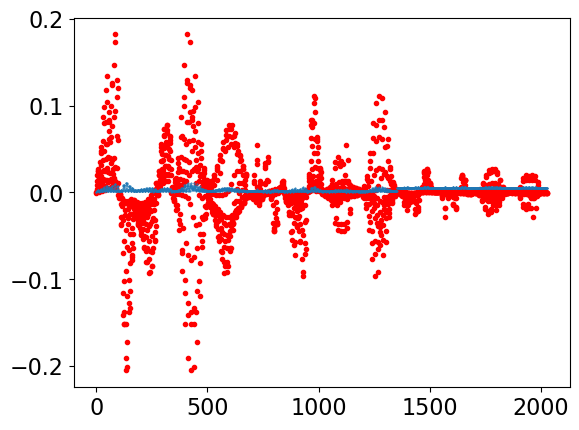

In [18]:
# np.save('Lb-imp_all-obs.npy', survey.dobs)
# np.save('Lb-imp-all-dpred_pre.npy', invProb.dpred)
# plt.plot(mkvc(stdnew), '.r')
# plt.plot(survey.std, '.', ms=1)
# plt.show()

## Fill the data object
fwd_data.dobs = sim.survey.dobs
fwd_data.standard_deviation = stdnew.flatten()  # sim.survey.std
sim.survey.std = stdnew.flatten()
survey.std = stdnew.flatten()

plt.plot(survey.dobs, '.r')
plt.plot(survey.std, '.', ms=1)
plt.show()

## Inversion

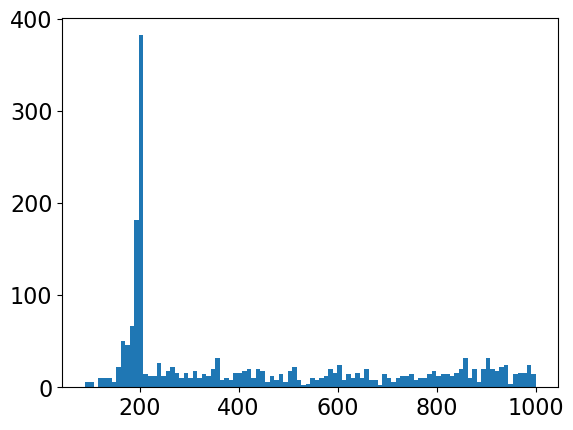

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\operators\inner_products.py:48: FutureWarning: The invMat keyword argument has been deprecated, please use invert_matrix. This will be removed in discretize 1.0.0
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh.cellGrady has been deprecated, please use TreeMesh.cell_gradient_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh.cellGradz has been deprecated, please use TreeMesh.cell_gradient_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.getEdgeInnerProduct has been deprecated, please use TreeMesh.get_edge_inner_product. It wil

SimPEG.SaveModelEveryIteration will save your models as: '.\###-InversionModel-2023-04-14-22-37.npy'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.23e-02  6.91e+04  4.44e-27  6.91e+04    2.75e+03      0              
   1  3.23e-02  1.10e+04  2.54e+05  1.92e+04    9.13e+02      0              
   2  3.23e-02  4.66e+03  2.91e+05  1.41e+04    2.29e+02      0   Skip BFGS  
   3  1.61e-02  3.35e+03  2.89e+05  8.01e+03    1.97e+02      0   Skip BFGS  
   4  1.61e-02  1.67e+03  3.47e+05  7.27e+03    8.57e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 7.3400e+02 <= tolF*(1+|f0|) = 6.9068e+03
1 : |xc-x_last| = 9.4422e+00 <= tolX*(1+|x0|) = 8.6058e+01
0 : |proj(x-g)-x|    = 8.5725e+01 <= tolG          = 1.0000e-

In [19]:
# Set the conductivity values
sig_half = 0.01
sig_air = 1e-8
# Make the background model
sigma_0 = np.ones(mesh.nC) * sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

Wd = 1 / survey.std
plt.hist(Wd, 100)
plt.show()
# Setup the inversion proceedure
# Define a counter
C = utils.Counter()
# Optimization
opt = optimization.ProjectedGNCG(maxIter=8, upper=np.inf, lower=-np.inf, tolCG=1E-2, maxIterCG=20)
opt.counter = C
opt.maxIterCG = 20
# opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = data_misfit.L2DataMisfit(data=fwd_data, simulation=sim)
dmis.W = Wd
# Regularization
regmap = maps.IdentityMap(nP=int(active.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)
reg = regularization.Tikhonov(mesh, indActive=active, mapping=regmap, reference_model=m_0)

reg.alpha_s = 2.5e-5
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 0.25
# reg.mrefInSmooth = True
# Inversion problem
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta schedule
beta = directives.BetaSchedule()
beta.coolingRate = 3.
beta.coolingFactor = 5.
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=0.1)
# Target misfit stop
targmis = directives.TargetMisfit()
# targmis.target = survey.nD
saveIter = directives.SaveModelEveryIteration()
# Create an inversion object
directive_list = [beta, beta_est, targmis, saveIter]
inv = inversion.BaseInversion(invProb, directiveList=directive_list)

import time
start = time.time()
# Run the inversion
mopt = inv.run(m_0)
print('Inversion took {0} seconds'.format(time.time() - start))

In [20]:
print(invProb.beta, invProb.phi_d, invProb.phi_m, sim.survey.nD)
# map the conductivity
cond_est = mapping * mopt

discretize.TreeMesh.writeUBC(mesh,'Lb-imp_all_simple-octree-v3.msh', models={'Lb-imp_all_simple-octree-v3.con': cond_est})

0.01612717184205256 1671.9659982945377 347396.8975794543 2028


c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.writeUBC has been deprecated, please use TreeMesh.write_UBC. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


## Model Comparison

In [21]:
# load the ubc model

# load the conductivity model
ubc_conductivity_file = r".\octree_model\inv_003.con"
ubc_model = discretize.TreeMesh.readModelUBC(mesh, ubc_conductivity_file)

print(invProb.phi_d)

1671.9659982945377


c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.readModelUBC has been deprecated, please use TreeMesh.read_model_UBC. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


### Load dpred of UBC

In [22]:
ubc_read = np.genfromtxt(r".\data_input\dpred_003.txt")

frequencies = [10, 50, 200]
# organise data by frequency index
ubc_pdat = {}

for ii in range(len(frequencies)):

    ubc_pdat[ii] = {

        'tzxr': [],
        'tzxi': [],
        'tzyr': [],
        'tzyi': [],
    }

fcnt = 0
findx = 0

for ii in range(ubc_read.shape[0]):

    if len(ubc_read[ii, :]) > 1:

        if fcnt == 169:

            fcnt = 0
            findx += 1

            ubc_pdat[findx]['tzxr'] += [ubc_read[ii, 5]]
            ubc_pdat[findx]["tzxi"] += [-ubc_read[ii, 6]]
            ubc_pdat[findx]['tzyr'] += [ubc_read[ii, 3]]
            ubc_pdat[findx]["tzyi"] += [-ubc_read[ii, 4]]

        else:

            ubc_pdat[findx]['tzxr'] += [ubc_read[ii, 5]]
            ubc_pdat[findx]["tzxi"] += [-ubc_read[ii, 6]]
            ubc_pdat[findx]['tzyr'] += [ubc_read[ii, 3]]
            ubc_pdat[findx]["tzyi"] += [-ubc_read[ii, 4]]

        fcnt += 1

# print(len(ubc_dat[findx - 1]['tzxr']))

# now create a vectore similar to dobs in simpeg
ubc_pred = []

for ii in range(3):

    ubc_pred += ubc_pdat[ii]['tzxr']
    ubc_pred += ubc_pdat[ii]['tzxi']
    ubc_pred += ubc_pdat[ii]['tzyr']
    ubc_pred += ubc_pdat[ii]['tzyi']

print(np.array(ubc_pred).shape)
ubc_pred = np.array(ubc_pred)

# do the ubc data
ubc_dpred = np.reshape(ubc_pred, (num_frequencies, num_sets))

(2028,)


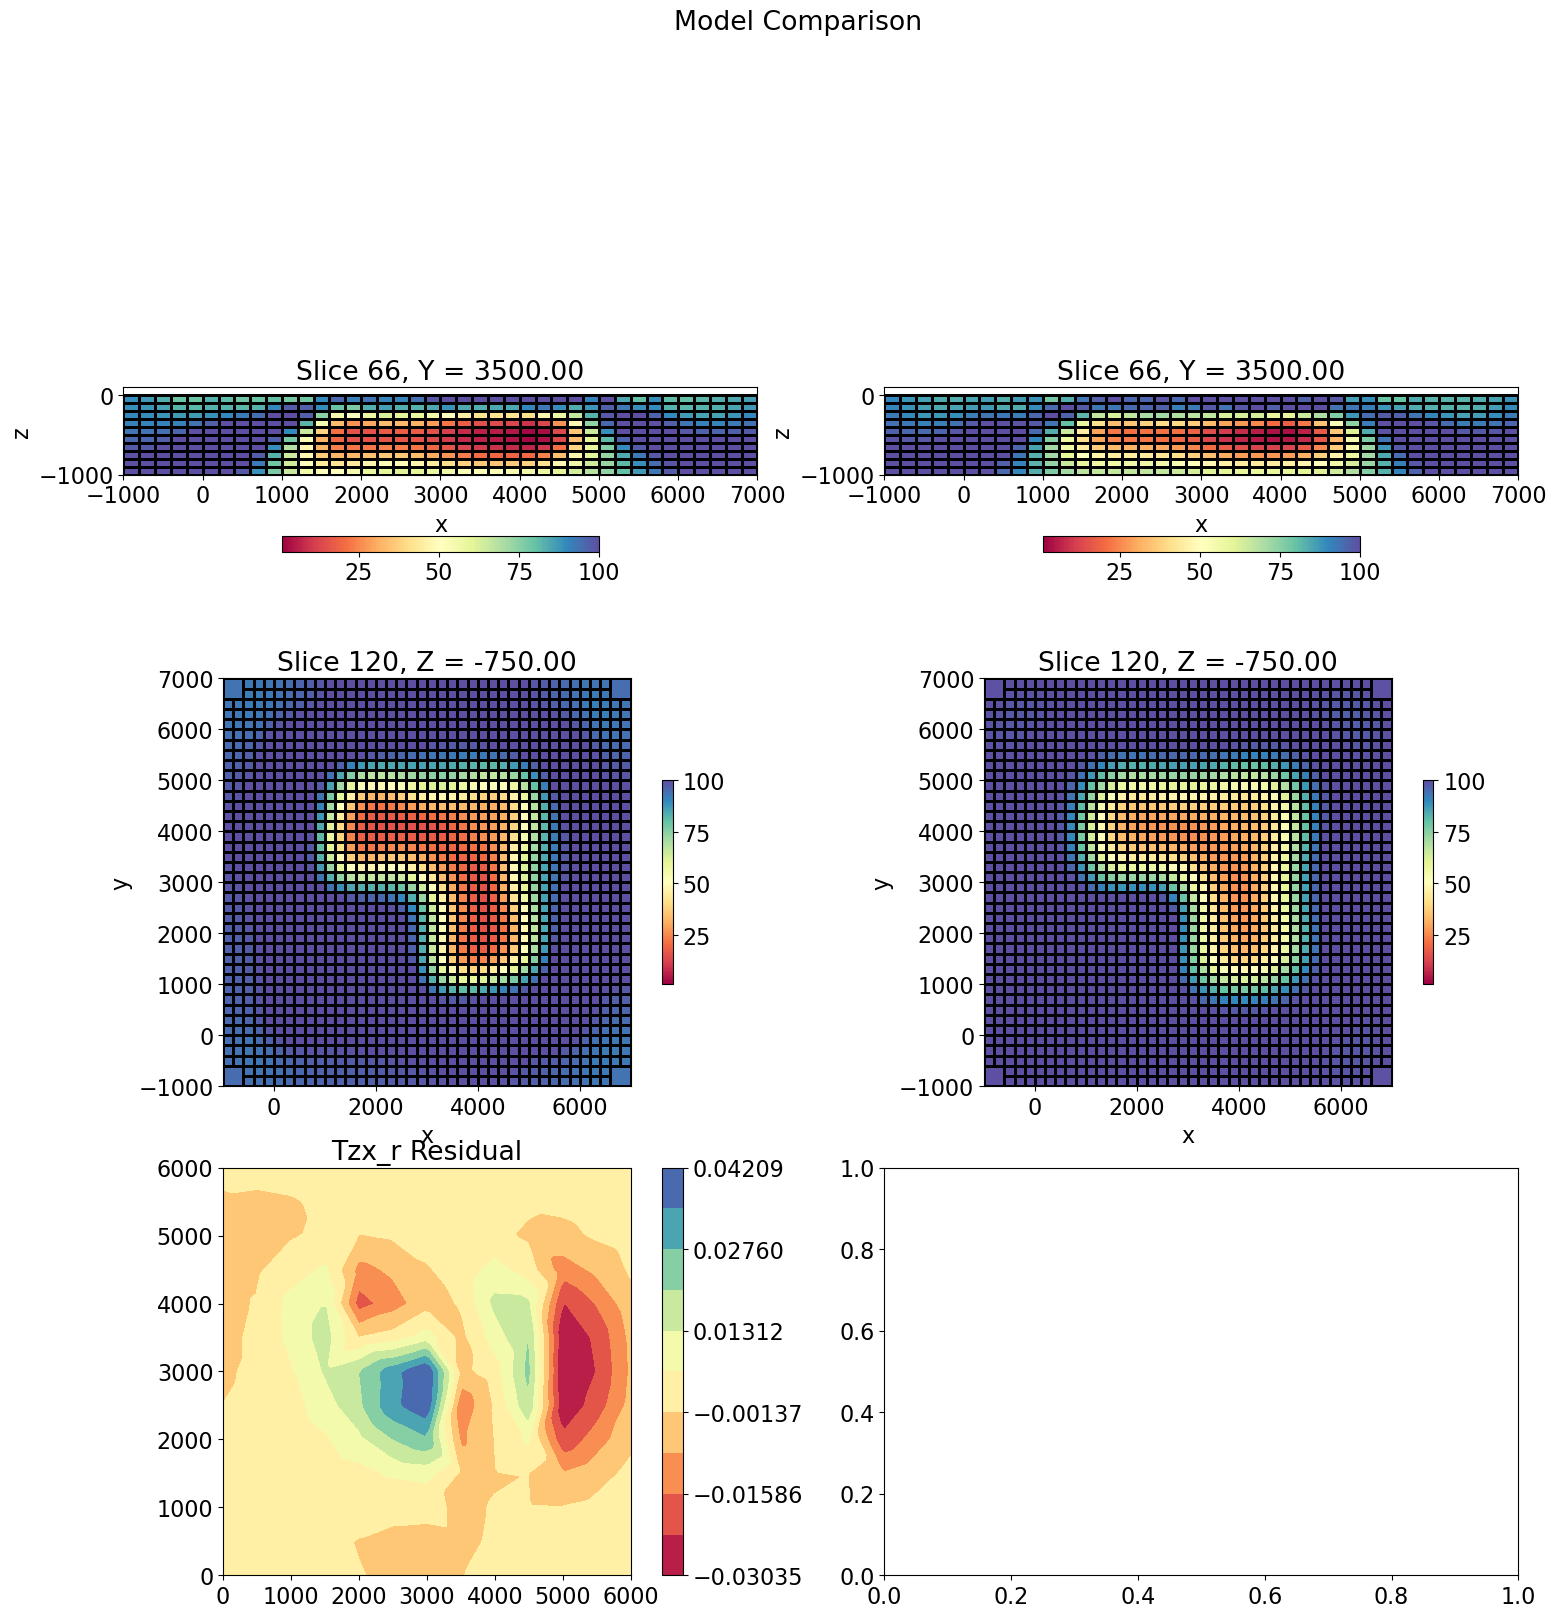

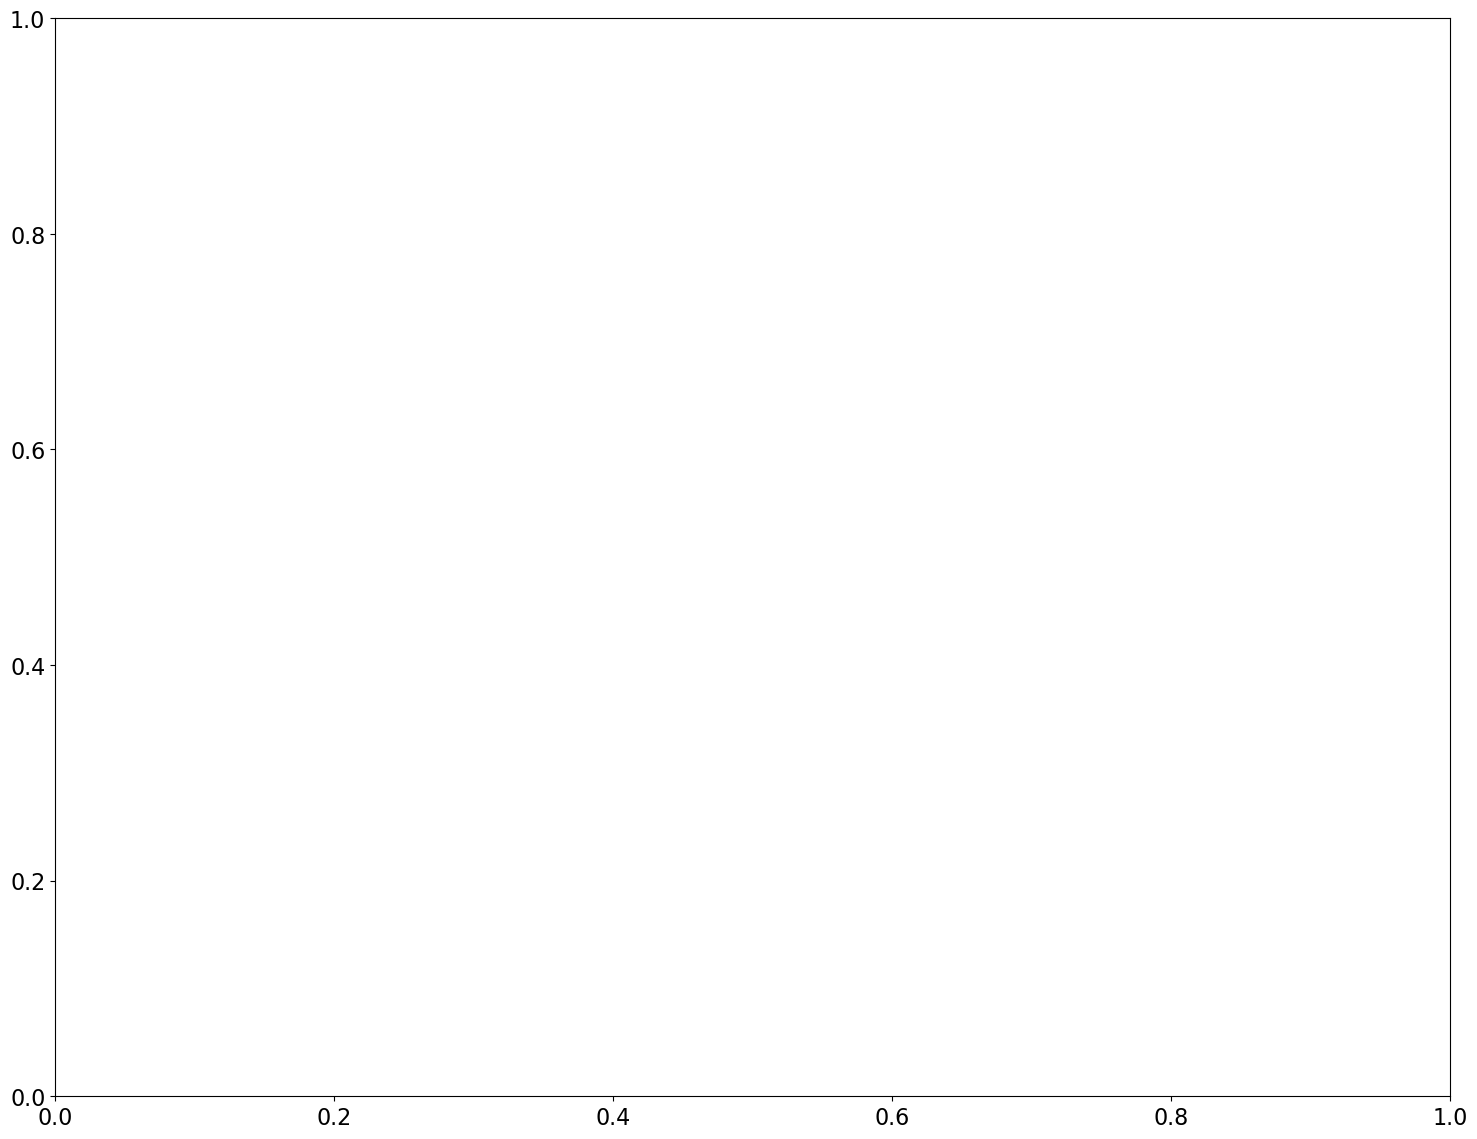

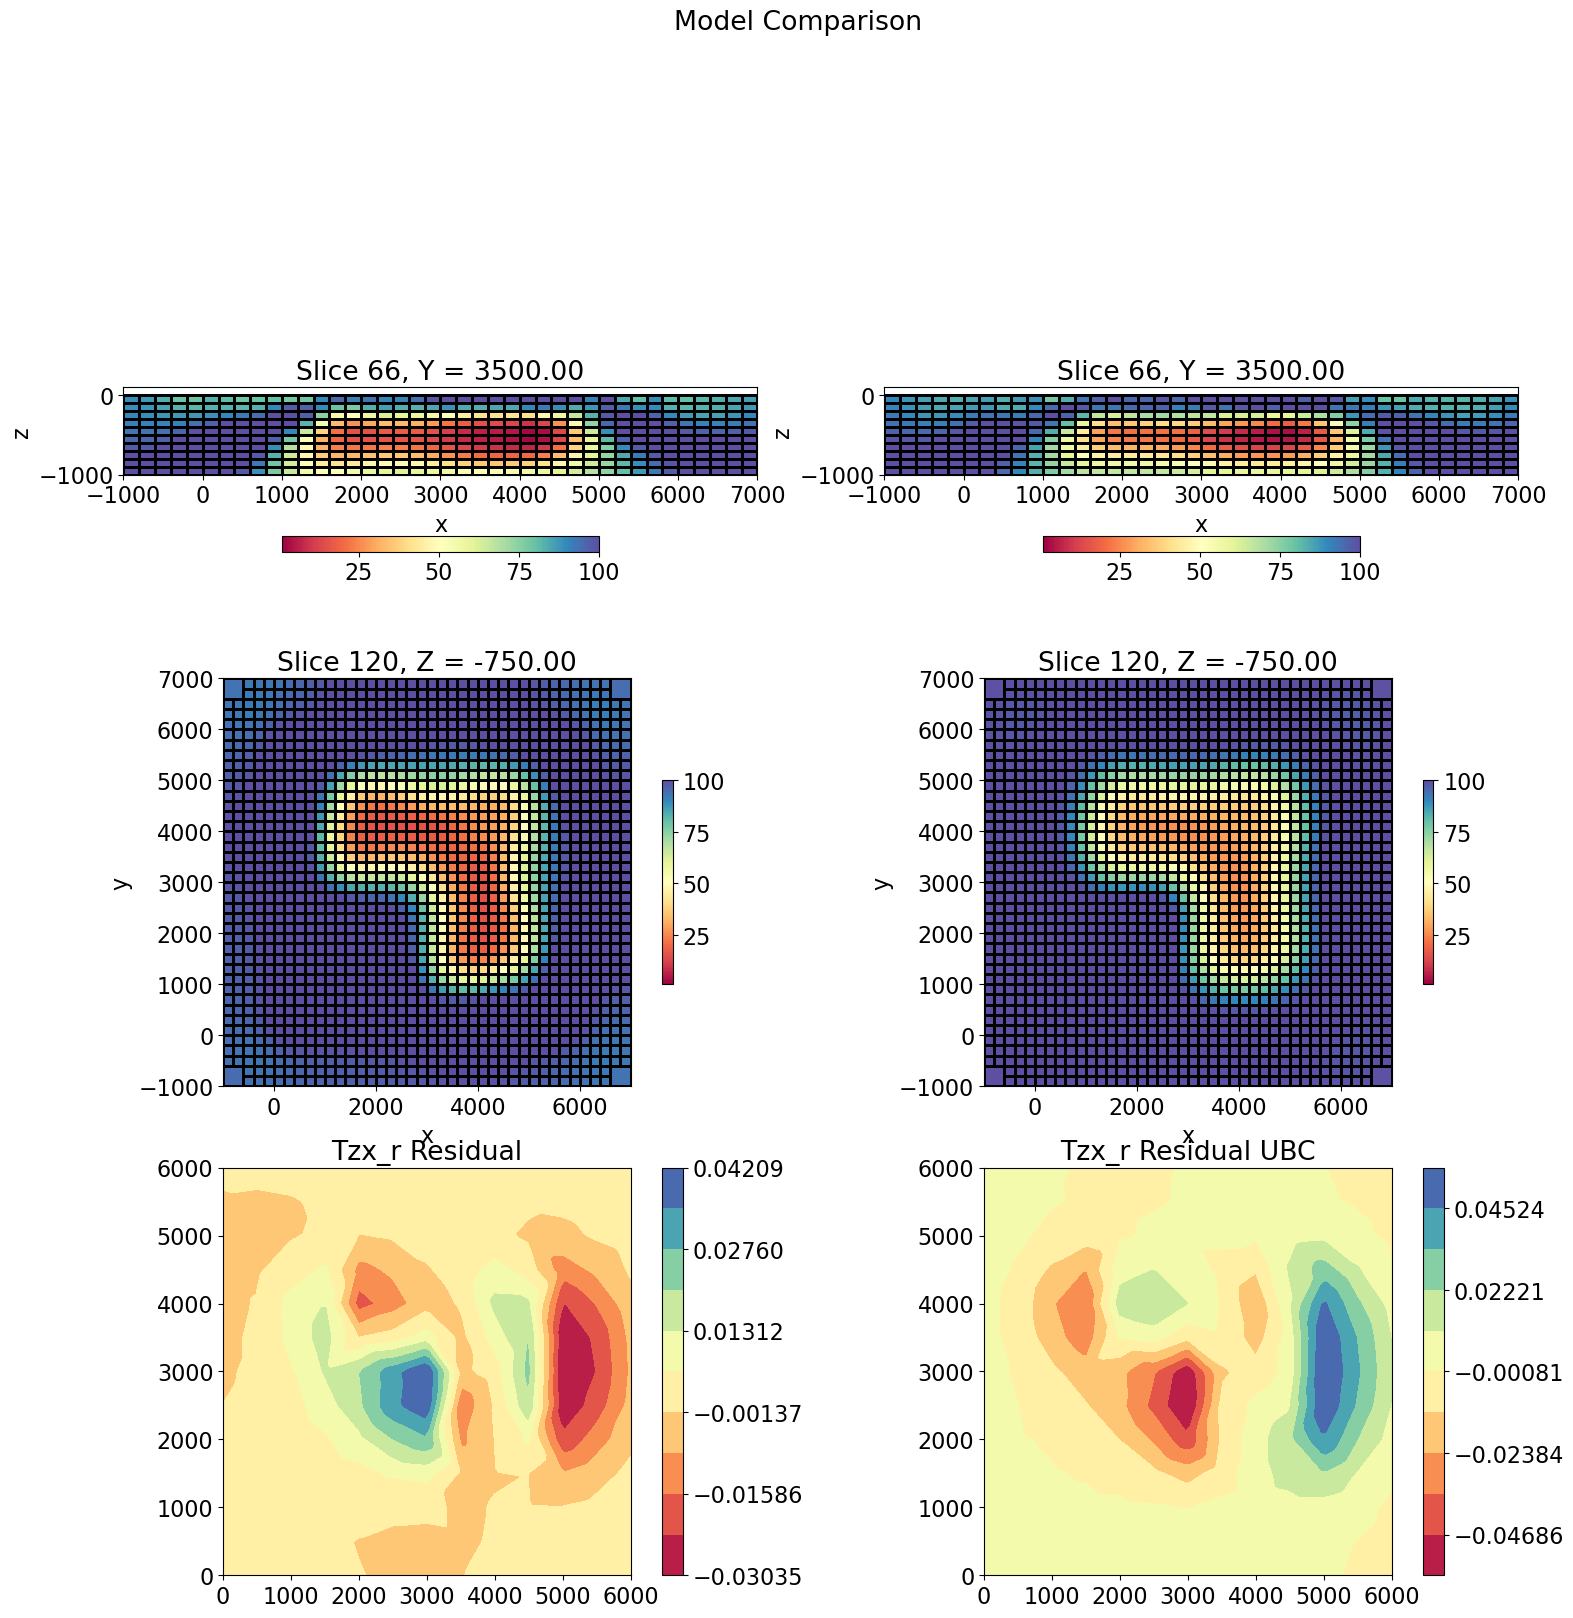

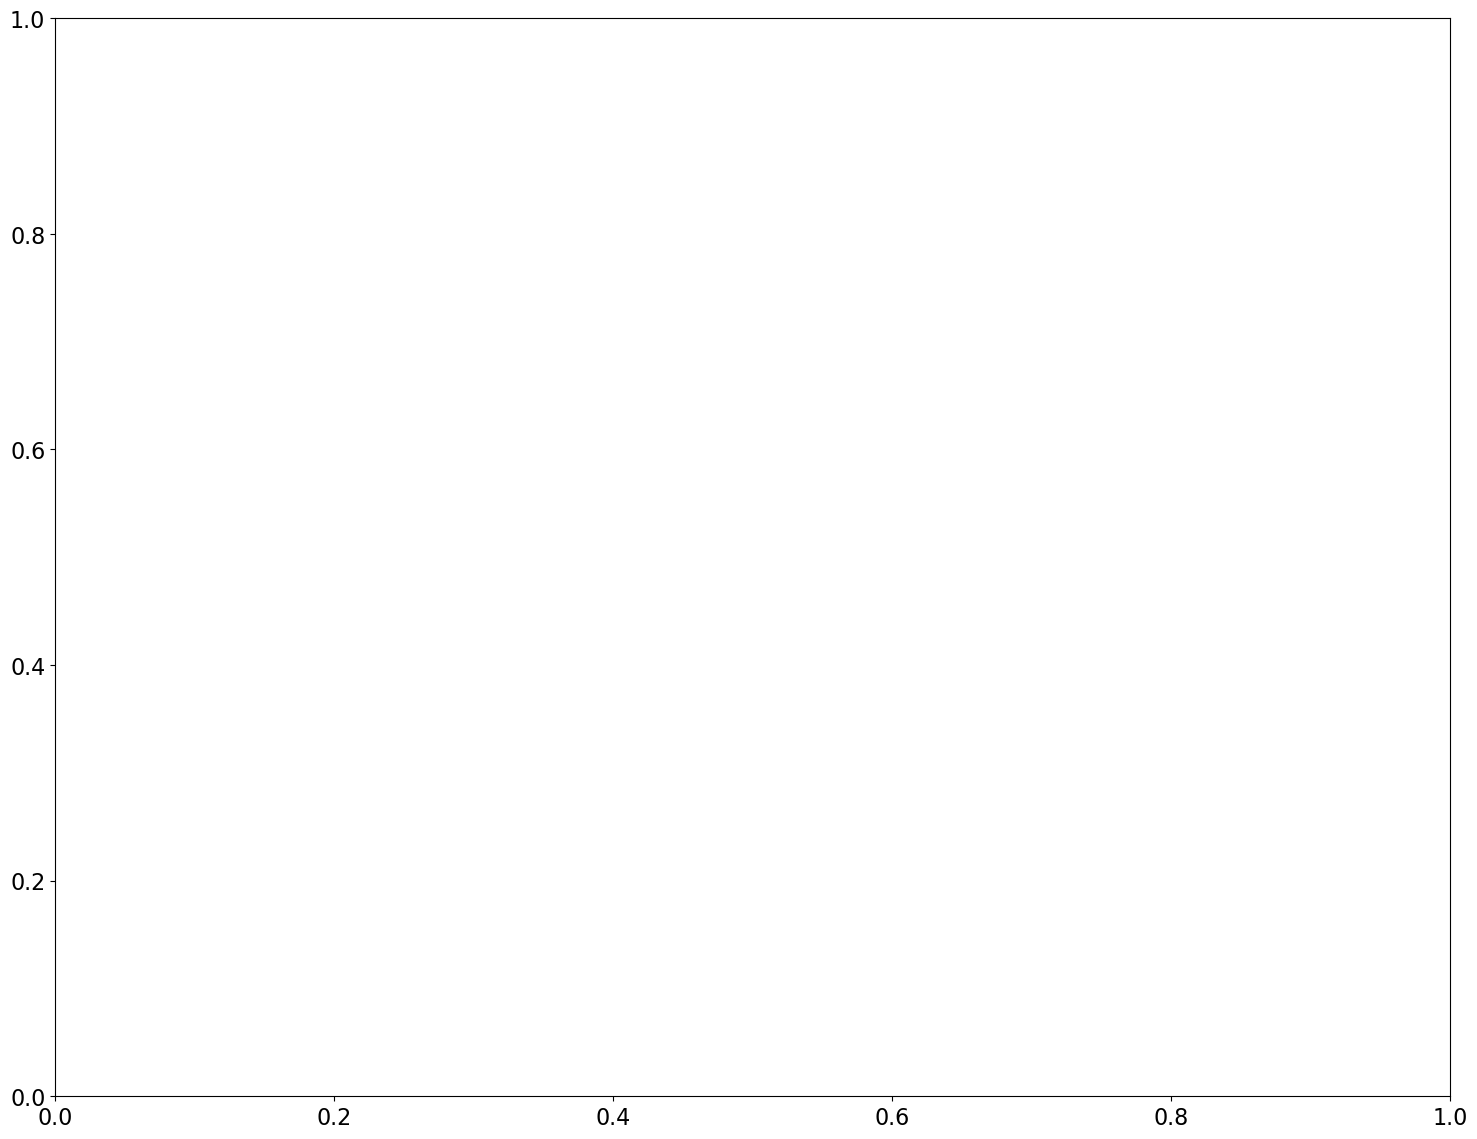

In [24]:
# cond_est = np.ones(mesh.nC)
# cond_est[active] = np.exp(np.load(r"002-InversionModel-2023-04-14-11-05.npy"))
# modeli = np.ones(mesh.nC) 
modeli = 1 / cond_est
modeli[~active] = np.nan
modeli_ubc = 1 / ubc_model
modeli_ubc[~active] = np.nan

plt.figure(figsize=(18, 18))
plt.suptitle('Model Comparison')
ax = plt.subplot(3, 2, 1)
collect_obj = mesh.plot_slice(modeli, ax=ax, ind=int(66), grid=True, normal='Y', clim=[1, 100], pcolor_opts={'cmap':'Spectral'})
color_bar = plt.colorbar(collect_obj[0], shrink=0.5, orientation='horizontal')
ax.set_xlim([-1000, 7000])
ax.set_ylim([-1000, 100])
ax.set_aspect('equal')

ax1 = plt.subplot(3, 2, 2)
collect_obj1 = mesh.plot_slice(modeli_ubc, ax=ax1, ind=int(66), grid=True, normal='Y', clim=[1, 100], pcolor_opts={'cmap':'Spectral'})
color_bar1 = plt.colorbar(collect_obj1[0], shrink=0.5, orientation='horizontal')
ax1.set_xlim([-1000, 7000])
ax1.set_ylim([-1000, 100])
ax1.set_aspect('equal')

ax2 = plt.subplot(3, 2, 3)
collect_obj2 = mesh.plot_slice(modeli, ax=ax2, ind=int(120), grid=True, normal='Z', clim=[1, 100], pcolor_opts={'cmap':'Spectral'})
color_bar2 = plt.colorbar(collect_obj2[0], shrink=0.5)
ax2.set_xlim([-1000, 7000])
ax2.set_ylim([-1000, 7000])
ax2.set_aspect('equal')

ax3 = plt.subplot(3, 2, 4)
collect_obj3 = mesh.plot_slice(modeli_ubc, ax=ax3, ind=int(120), grid=True, normal='Z', clim=[1, 100], pcolor_opts={'cmap':'Spectral'})
color_bar3 = plt.colorbar(collect_obj3[0], shrink=0.5)
ax3.set_xlim([-1000, 7000])
ax3.set_ylim([-1000, 7000])
ax3.set_aspect('equal')

# need to add residual map

num_sets = int(survey.dobs.shape[0] / 3.)
dnew = np.reshape(survey.dobs, (3, num_sets))
dpred_new = np.reshape(invProb.dpred, (3, num_sets))
d_wd = dmis.W.diagonal()
Wd_new = np.reshape(d_wd, (3, num_sets))
ax4 = plt.subplot(3, 2, 5)
ax5 = plt.subplot(3, 2, 6)
cnt = 0
for freq in [freqs[0]]:
    cnt_comp = 0

    for rx_orientation in range(len(comps_)):

        if comps_[rx_orientation] == 'Tzx_r':

            residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                        dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            im = utils.plot_utils.plot2Ddata(receivers, residual, ax=ax4, contourOpts={'cmap':'Spectral'})
            ax4.set_title(f"{comps_[rx_orientation]} Residual")
            plt.colorbar(im[0])

            residual_ubc = (ubc_dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                            ubc_dpred[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            im = utils.plot_utils.plot2Ddata(receivers, residual_ubc, ax=ax5, contourOpts={'cmap':'Spectral'})
            ax5.set_title(f"{comps_[rx_orientation]} Residual UBC")
            plt.colorbar(im[0])

            cnt_comp += 1

        # elif comps_[rx_orientation] == 'Tzx_i':
    cnt += 1

plt.show()

# print(mesh.nCz)

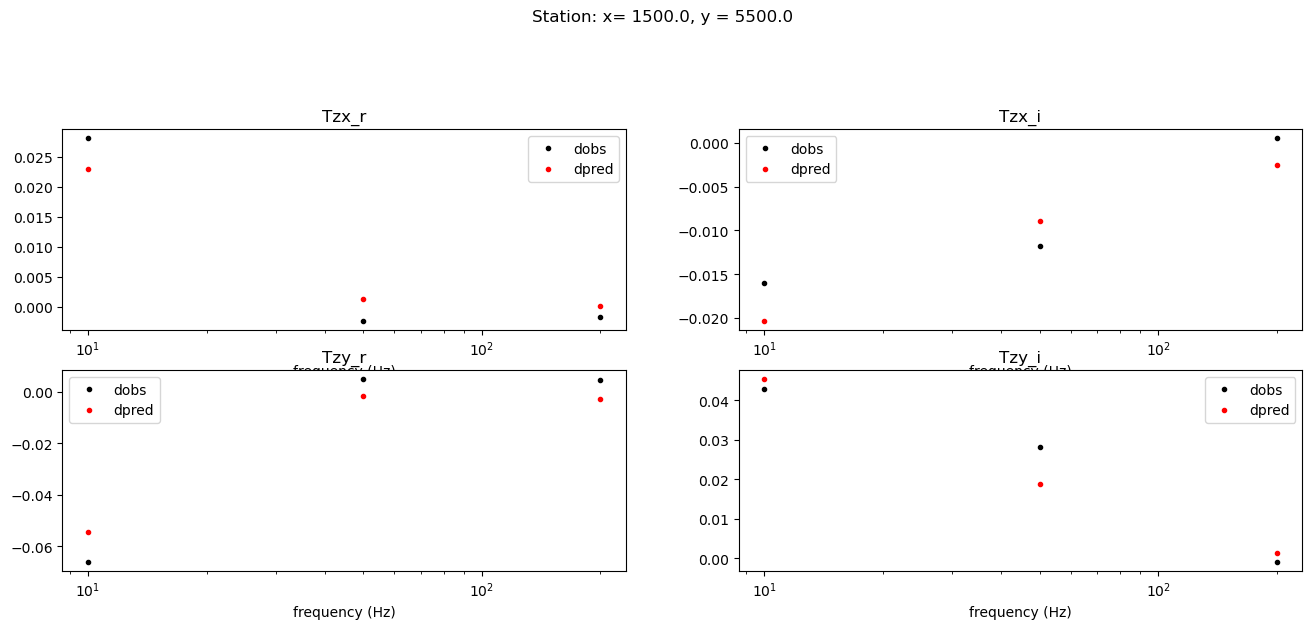

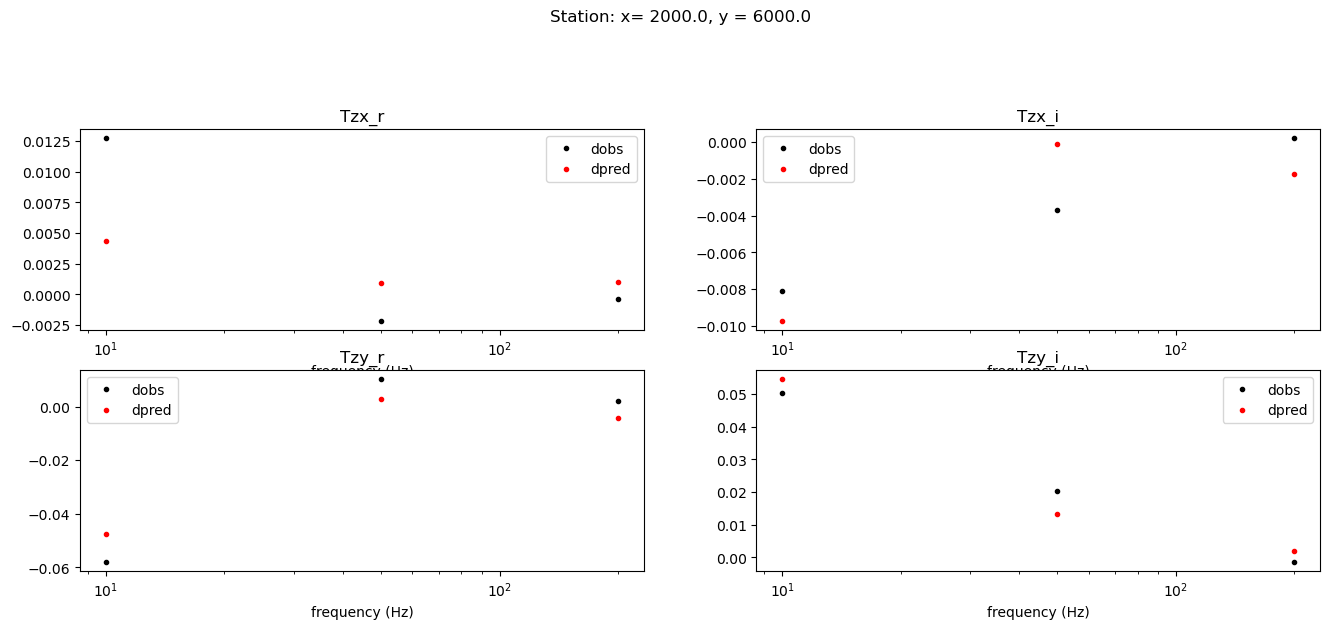

In [160]:
# plot dpred & dobs for specific station - checking fit of each frequency for a station
num_sets = int(survey.dobs.shape[0] / 3.)
dnew = np.reshape(survey.dobs, (3, num_sets))
dpred_new = np.reshape(invProb.dpred, (3, num_sets))
d_wd = dmis.W.diagonal()
Wd_new = np.reshape(d_wd, (3, num_sets))
# set station ID
stn_id = 50
location_id = receivers[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in comps_:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.frequencies, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.frequencies, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()

# set second station ID
stn_id = 64
location_id = receivers[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in comps_:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.frequencies, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.frequencies, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()

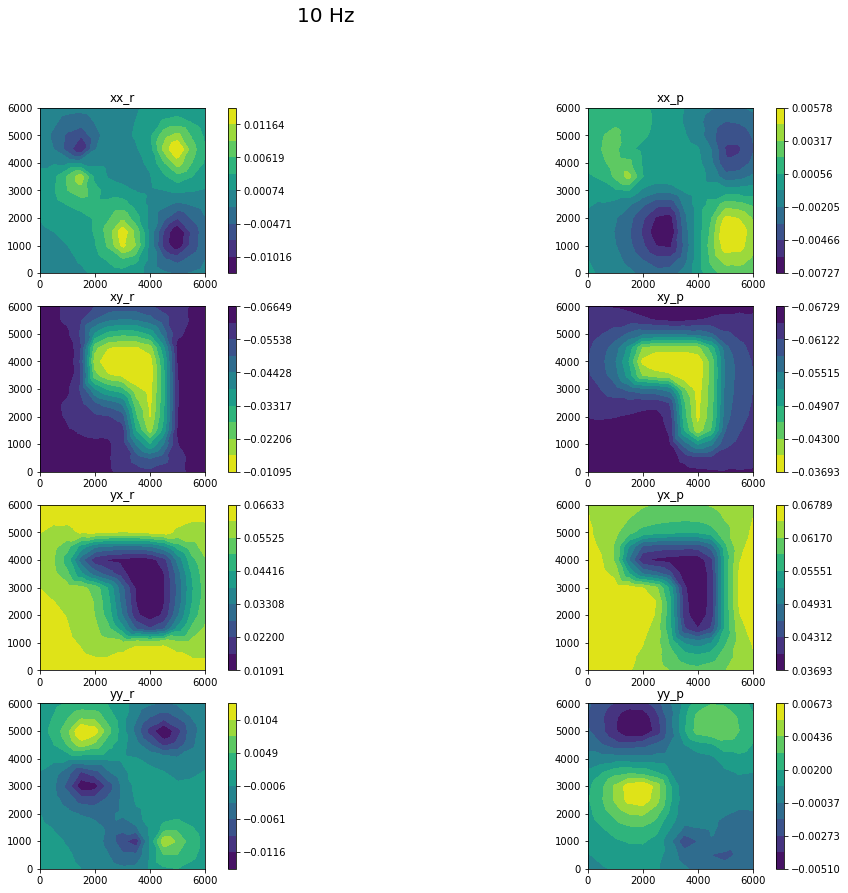

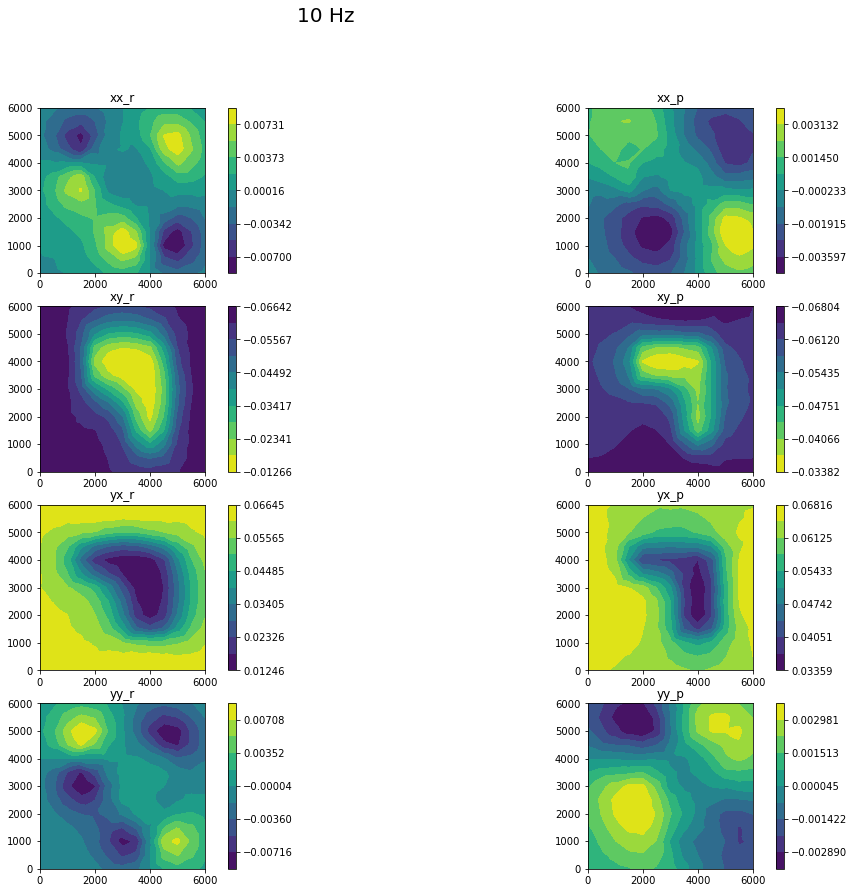

In [91]:
# plotting obs maps
freqs = ['10', '50', '200']
cnt = 0
cnt_comp = 0
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']
fig1 = plt.figure(figsize=(18, 14))
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = utils.plot_utils.plot2Ddata(rx_loc, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig1.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

# plotting dpred maps
fig2 = plt.figure(figsize=(18, 14))
cnt_comp = 0
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = utils.plot_utils.plot2Ddata(rx_loc, dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig2.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

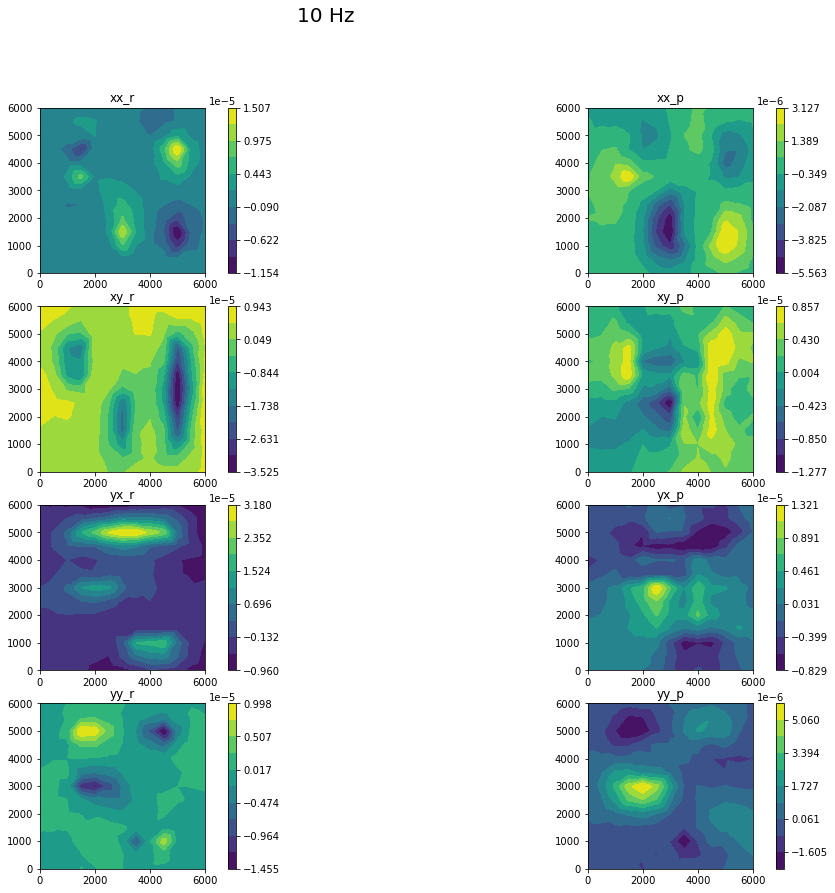

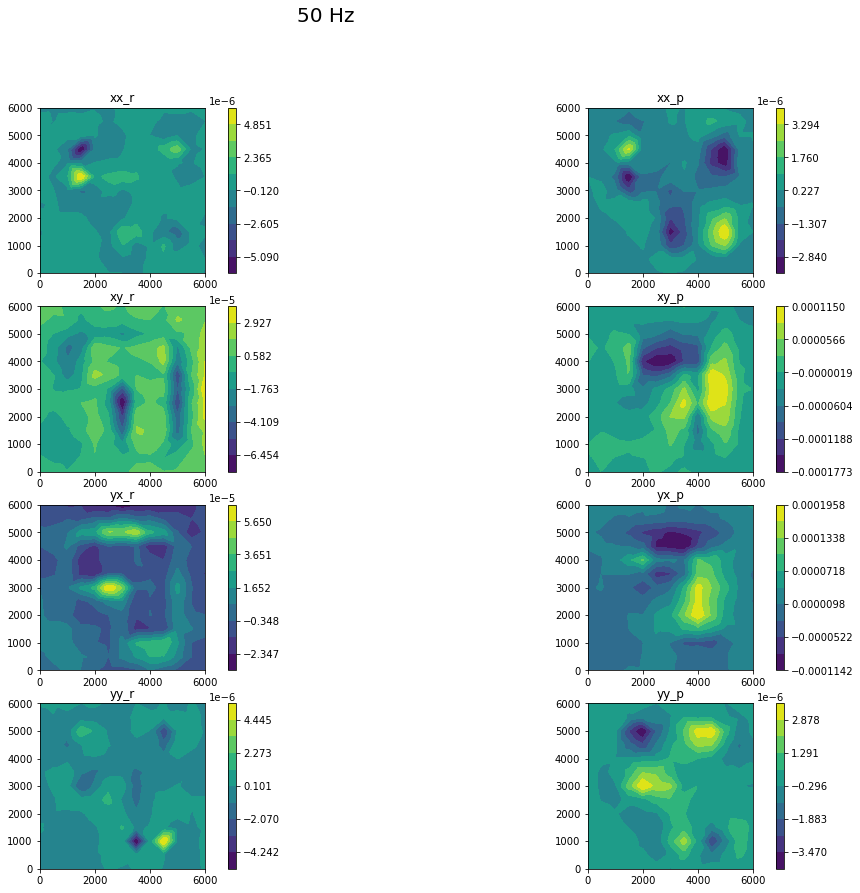

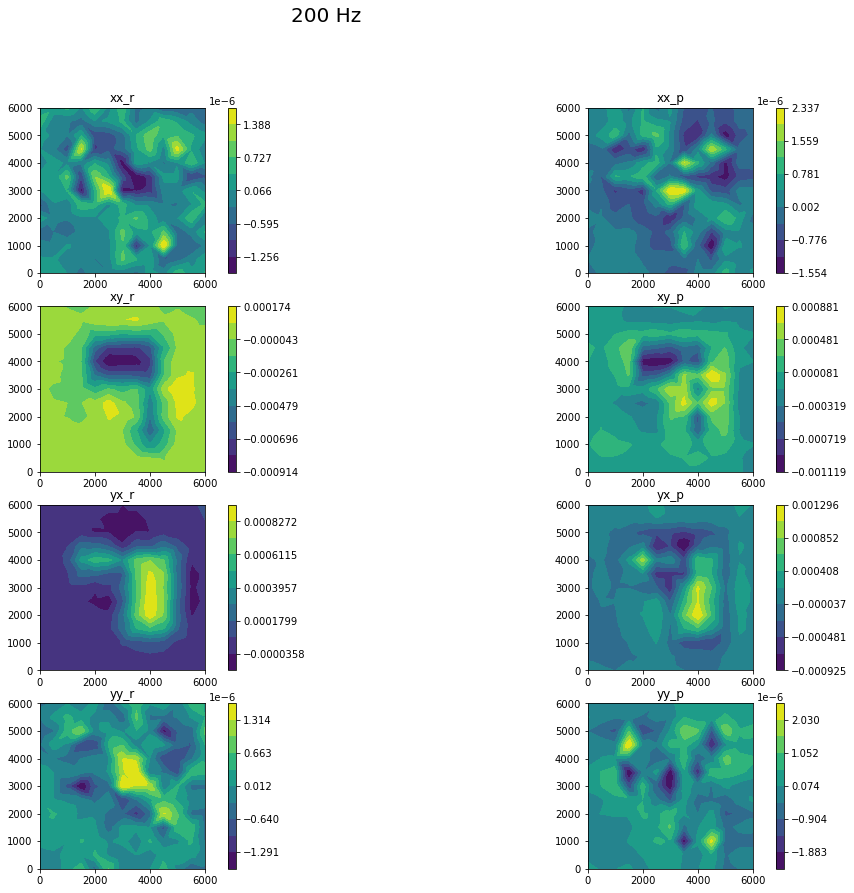

In [92]:
# plotting residual maps
freqs = ['10', '50', '200']
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']

cnt = 0
for freq in freqs:
    cnt_comp = 0
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                    dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]) / Wd_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]
        im = utils.plot_utils.plot2Ddata(rx_loc, residual, ax=ax)
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(freq + ' Hz', fontsize='20')
plt.show()

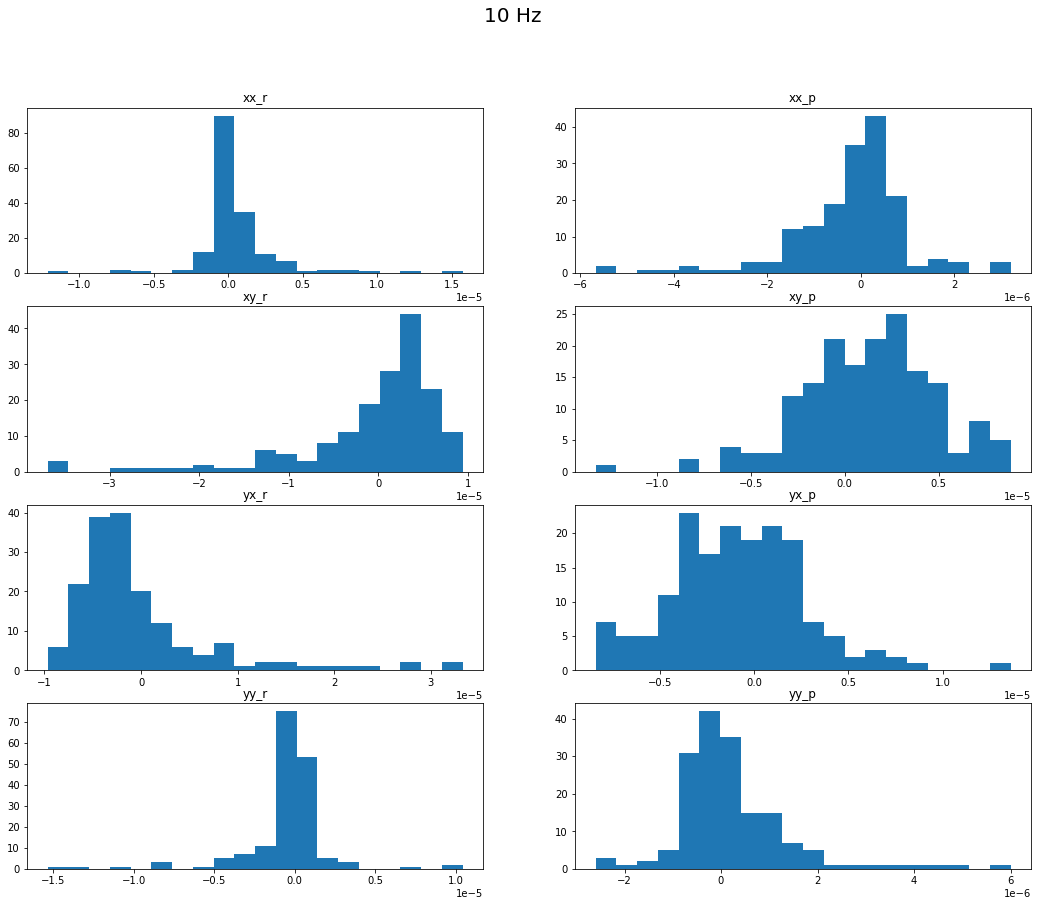

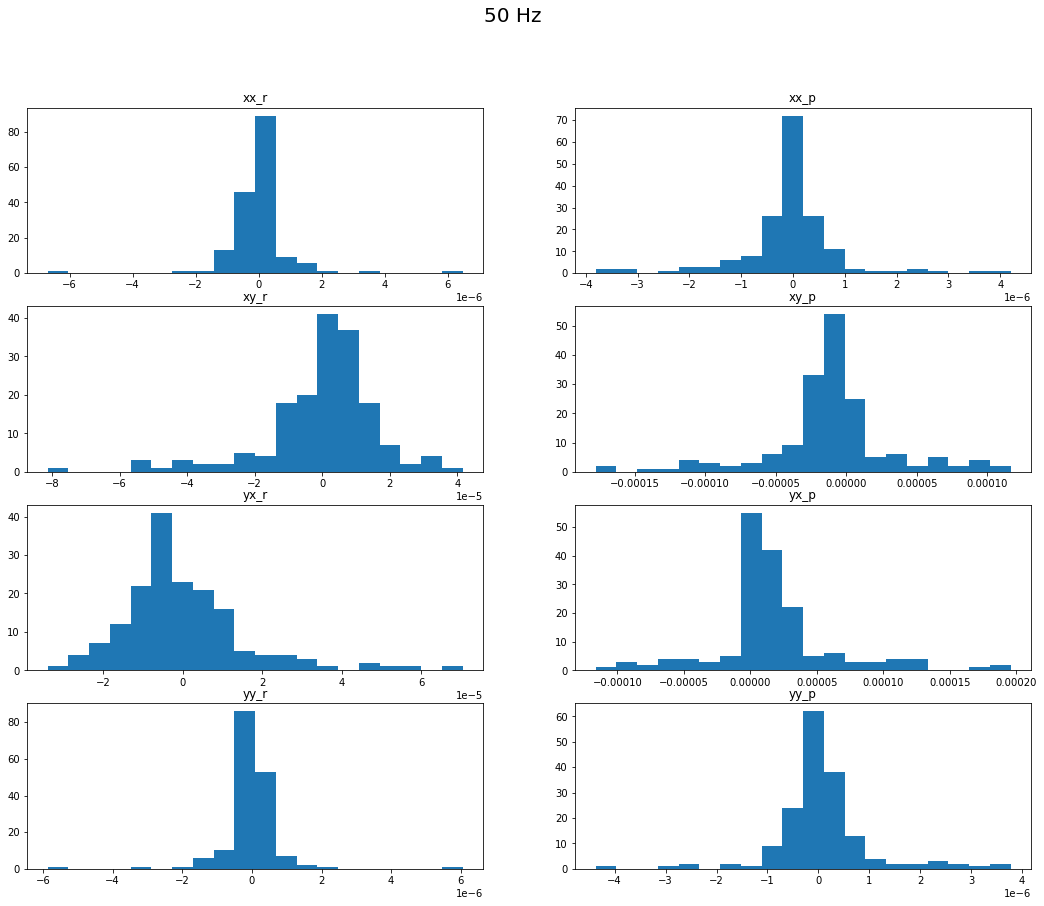

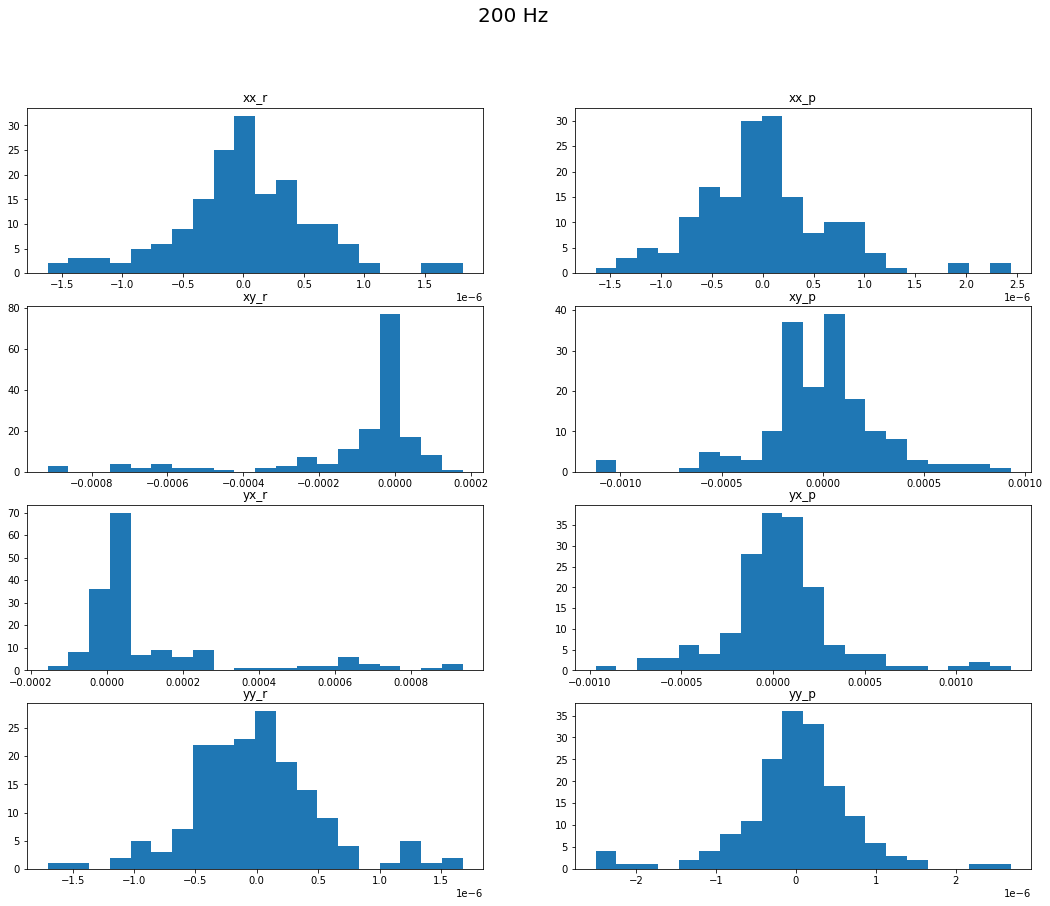

In [93]:
# plotting residual histograms
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']
cnt = 0
for freq in freqs:
    cnt_comp = 0
    fig = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                    dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]) / Wd_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]
        ax.hist(residual, 20)
        ax.set_title(comps_[rx_orientation])
        cnt_comp += 1
    cnt += 1
    fig.suptitle(freq + ' Hz', fontsize='20')
plt.show()

In [ ]:
np.save('Lb-imp_all-octree-obs-v2.npy', survey.dobs)
np.save('Lb-imp_all-octree-dpred-v2.npy', invProb.dpred)
np.save('Lb-imp_all-octree-dmis-v2.npy', d_wd)
print(5000 / 60)